<a href="https://colab.research.google.com/github/eunicean/Proyecto-DeepLearning/blob/main/CNN/drawing_hiragana_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/eunicean/Proyecto-DeepLearning.git

Cloning into 'Proyecto-DeepLearning'...
remote: Enumerating objects: 4782, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 4782 (delta 8), reused 13 (delta 3), pack-reused 4758 (from 2)
Receiving objects: 100% (4782/4782), 52.86 MiB | 10.18 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Updating files: 100% (4621/4621), done.


In [2]:
# pa pintar
!pip install ipycanvas pillow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00


In [3]:
!pip install lime scikit-image -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
from google.colab import output
output.enable_custom_widget_manager()

In [5]:
# Imports y configuración
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
from ipycanvas import Canvas, hold_canvas
from ipywidgets import Button, HBox, VBox, Output, Layout
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import random

In [6]:


# Configuración
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 1

# Cargar modelo
MODEL_PATH = '/content/Proyecto-DeepLearning/models/best_cnn_hiragana_model.h5'
model = keras.models.load_model(MODEL_PATH)
print("Modelo cargado")

# Definir clases (orden alfabético - mismo que entrenamiento)
class_labels = ['aa', 'chi', 'ee', 'fu', 'ha', 'he', 'hi', 'ho', 'ii',
                'ka', 'ke', 'ki', 'ko', 'ku', 'ma', 'me', 'mi', 'mo',
                'mu', 'na', 'ne', 'ni', 'nn', 'no', 'nu', 'oo', 'ra',
                're', 'ri', 'ro', 'ru', 'sa', 'se', 'shi', 'so', 'su',
                'ta', 'te', 'tsu', 'to', 'uu', 'wa', 'wo', 'ya', 'yo', 'yu']

Modelo cargado


In [7]:
# Canvas y variables
canvas_size = 400
visual_size = 300

canvas = Canvas(
    width=canvas_size,
    height=canvas_size,
    sync_image_data=True,
    layout=Layout(width=f'{visual_size}px', height=f'{visual_size}px')
)

canvas.fill_style = 'white'
canvas.fill_rect(0, 0, canvas_size, canvas_size)
canvas.stroke_style = 'black'
canvas.line_width = 15

drawing = False
last_x = 0
last_y = 0
output = Output()

RANDOM_OBJECTIVE_LETTER = random.choice(class_labels)
print(f"LETRA A DIBUJAR: {RANDOM_OBJECTIVE_LETTER}")

# Funciones de dibujo
def on_mouse_down(x, y):
    global drawing, last_x, last_y
    drawing = True
    last_x = x
    last_y = y

def on_mouse_move(x, y):
    global drawing, last_x, last_y
    if drawing:
        with hold_canvas(canvas):
            canvas.stroke_style = 'black'
            canvas.line_width = 15
            canvas.begin_path()
            canvas.move_to(last_x, last_y)
            canvas.line_to(x, y)
            canvas.stroke()
            last_x = x
            last_y = y

def on_mouse_up(x, y):
    global drawing
    drawing = False

canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)

# Funciones de control
def change_letter(button):
    global RANDOM_OBJECTIVE_LETTER
    RANDOM_OBJECTIVE_LETTER = random.choice(class_labels)
    canvas.clear()
    canvas.fill_style = 'white'
    canvas.fill_rect(0, 0, canvas_size, canvas_size)
    with output:
        clear_output()
        print(f"Nueva letra: {RANDOM_OBJECTIVE_LETTER}")

def clear_canvas(button):
    global RANDOM_OBJECTIVE_LETTER
    canvas.clear()
    canvas.fill_style = 'white'
    canvas.fill_rect(0, 0, canvas_size, canvas_size)
    with output:
        clear_output()
        print(f"Canvas limpiado - Letra actual: {RANDOM_OBJECTIVE_LETTER}")

def predict_drawing(button):
    global RANDOM_OBJECTIVE_LETTER
    with output:
        clear_output()
        print(f"Letra objetivo: {RANDOM_OBJECTIVE_LETTER}")
        print("Analizando...\n")

        try:
            img_data = canvas.get_image_data()
            img_array = np.array(img_data, dtype=np.uint8)

            if img_array.size == 0:
                print("No hay dibujo")
                return

            img_gray = img_array[:, :, 0]
            img_pil = Image.fromarray(img_gray, mode='L')
            img_resized = img_pil.resize((64, 64), Image.Resampling.LANCZOS)
            img_normalized = np.array(img_resized) / 255.0
            img_input = img_normalized.reshape(1, 64, 64, 1)

            prediction = model.predict(img_input, verbose=0)

            predicted_idx = np.argmax(prediction[0])
            predicted_class = class_labels[predicted_idx]
            confidence = prediction[0][predicted_idx] * 100

            top_n = 10
            top_indices = np.argsort(prediction[0])[-top_n:][::-1]

            print(f"PREDICCION: {predicted_class}")
            print(f"CONFIANZA: {confidence:.2f}%")

            # la idea podria ser usar la predicción para darle una nota al usuario
            # ahora mismo el modelo es muy estricto con los dibujos
            # entonces podemos aprovechar eso para poder puntuar el dibujo
            # por ejemplo, si el usuario hace un dibujo muy bueno y la predicción 1
            # del modelo concuerda con lo que se le pidio dibujar al usuario tiene 10/10
            # si el usuario dibuja y el modelo predice como 4to candidato la clase solicitada
            # entonces tiene 6/10 puntos
            # para una nota sobre 10, se puede hacer una formula como 10 - x + 1
            # donde x es la posicion en la que quedó la clase objetivo en la predicción
            # por ejemplo
            # si se pide dibujar 'ka' y luego de que el usuario haga el dibujo
            # el modelo predice ka en la 4 posición, entonces la nota es
            # 10 - (4) + 1 = 7

            points = 0
            print(f"\nTop {top_n}:")
            for i, idx in enumerate(top_indices, 1):
                class_name = class_labels[idx]
                prob = prediction[0][idx] * 100
                print(f" {i}. {class_name:5s} : {prob:6.2f}%")

                if class_name == RANDOM_OBJECTIVE_LETTER:
                    points = 10 - i + 1

            print(f"\nPuntuacion: {points}/10")

        except Exception as e:
            print(f"Error: {e}")
            import traceback
            traceback.print_exc()

btn_clear = Button(description='Limpiar', button_style='warning')
btn_predict = Button(description='Predecir', button_style='success')
btn_cambiar = Button(description='Cambiar', button_style='info')

btn_clear.on_click(clear_canvas)
btn_predict.on_click(predict_drawing)
btn_cambiar.on_click(change_letter)

display(VBox([
    canvas,
    HBox([btn_clear, btn_predict, btn_cambiar]),
    output
]))

LETRA A DIBUJAR: aa


# LIME

In [8]:
def predict_proba(images):
    """
    Función de predicción para LIME

    Args:
        images: Array de imágenes RGB (N, H, W, 3)

    Returns:
        Array de probabilidades (N, 46)
    """
    # LIME pasa imágenes RGB, necesitamos convertir a escala de grises
    batch_size = images.shape[0]
    grayscale_images = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    for i in range(batch_size):
        # Convertir RGB a escala de grises
        img_rgb = images[i]
        img_gray = np.mean(img_rgb, axis=2)

        # Normalizar
        img_normalized = img_gray / 255.0

        # Añadir dimensión de canal
        grayscale_images[i] = img_normalized.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

    # Predecir
    predictions = model.predict(grayscale_images, verbose=0)

    return predictions

print("Función predict_proba creada")

Función predict_proba creada


In [9]:
# Crear el explicador LIME
explainer = lime_image.LimeImageExplainer()

print("Explicador LIME creado exitosamente")

Explicador LIME creado exitosamente


In [13]:
def process_and_predict_image(test_img_path, model):
  # Cargar y preprocesar
  img = Image.open(test_img_path).convert('L')
  img_resized = img.resize((64, 64))
  img_array = np.array(img_resized)

  # Hacer predicción
  img_normalized = img_array / 255.0
  img_input = img_normalized.reshape(1, 64, 64, 1)
  prediction = model.predict(img_input, verbose=0)
  predicted_idx = np.argmax(prediction[0])
  predicted_class = class_labels[predicted_idx]

  return img_array, predicted_class

In [10]:
def explain_hiragana_with_lime(image_to_explain, true_label, predicted_label, idx=0):
    """
    Explica la predicción del modelo usando LIME

    Args:
        image_to_explain: Imagen en escala de grises (64, 64)
        true_label: Etiqueta verdadera (string)
        predicted_label: Etiqueta predicha (string)
        idx: Índice de la imagen (para identificación)
    """

    print(f"\nEXPLICANDO IMAGEN")
    print(f"Etiqueta real: {true_label}")
    print(f"Predicción del modelo: {predicted_label}\n")

    # Convertir imagen a formato RGB (LIME requiere 3 canales)
    image_rgb = np.stack([image_to_explain]*3, axis=-1)

    # Obtener índice de la clase predicha
    predicted_idx = class_labels.index(predicted_label)

    # Generar explicación
    print("Generando explicación con LIME...")
    explanation = explainer.explain_instance(
        image_rgb,
        predict_proba,
        top_labels=3,
        hide_color=0,
        num_samples=1000
    )

    print("Explicación generada\n")

    # Obtener los pesos de las regiones
    local_exp = explanation.local_exp[predicted_idx]
    weights_dict = dict(local_exp)
    num_regions = len(weights_dict)

    # Obtener máscaras
    temp_all, mask_all = explanation.get_image_and_mask(
        predicted_idx,
        positive_only=False,
        num_features=num_regions,
        hide_rest=False
    )

    # Crear máscara de pesos
    segments = explanation.segments
    weight_mask = np.zeros_like(mask_all, dtype=float)

    for region_id, weight in weights_dict.items():
        weight_mask[segments == region_id] = weight

    # Calcular rangos dinámicamente
    all_weights = list(weights_dict.values())

    if len(all_weights) > 0:
        max_abs_weight = max(abs(min(all_weights)), abs(max(all_weights)))
        vmin, vmax = -max_abs_weight, max_abs_weight

        if max_abs_weight < 0.01:
            vmin, vmax = -0.01, 0.01
    else:
        vmin, vmax = -0.1, 0.1

    # Detectar caso de región única
    single_region = (num_regions == 1)

    if single_region:
        print("CASO ESPECIAL: LIME detectó solo 1 región (imagen completa)")
        print(f"  Peso único: {all_weights[0]:.4f}\n")
    else:
        print(f"Rango de visualización: [{vmin:.4f}, {vmax:.4f}]")
        print(f"Total de regiones: {num_regions}\n")

    # Visualización
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Imagen original
    axes[0, 0].imshow(image_to_explain, cmap='gray')
    axes[0, 0].set_title(f'Original\nReal: {true_label}, Predicho: {predicted_label}',
                         fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    # 2. Heatmap de pesos
    if single_region:
        weight_value = all_weights[0]
        colored_mask = np.ones_like(weight_mask)

        if weight_value > 0:
            axes[0, 1].imshow(colored_mask, cmap='Reds', vmin=0, vmax=1)
            title_text = f'Región Única: POSITIVA\nPeso: {weight_value:.4f}'
        else:
            axes[0, 1].imshow(colored_mask, cmap='Blues', vmin=0, vmax=1)
            title_text = f'Región Única: NEGATIVA\nPeso: {weight_value:.4f}'

        axes[0, 1].set_title(title_text, fontsize=11, fontweight='bold')
    else:
        im = axes[0, 1].imshow(weight_mask, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        axes[0, 1].set_title('Mapa de Importancia\n(Rojo=Apoya, Azul=Contradice)',
                             fontsize=11, fontweight='bold')
        plt.colorbar(im, ax=axes[0, 1], fraction=0.046, pad=0.04)

    axes[0, 1].axis('off')

    # 3. Segmentación
    overlay = mark_boundaries(image_to_explain, mask_all, color=(0, 1, 0), mode='thick')
    overlay = np.clip(overlay, 0, 1)
    axes[0, 2].imshow(overlay, cmap='gray')
    axes[0, 2].set_title(f'Segmentación: {num_regions} regiones',
                         fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')

    # 4. Regiones positivas
    positive_threshold = max(0.01, max_abs_weight * 0.1)
    positive_mask = np.where(weight_mask > positive_threshold, weight_mask, 0)

    if np.any(positive_mask > 0):
        im4 = axes[1, 0].imshow(positive_mask, cmap='Reds', vmin=0,
                                vmax=max(all_weights) if max(all_weights) > 0 else 0.1)
        if not single_region:
            plt.colorbar(im4, ax=axes[1, 0], fraction=0.046, pad=0.04)
        axes[1, 0].set_title(f'Regiones Positivas\n({np.sum(positive_mask > 0)} píxeles)',
                             fontsize=12, fontweight='bold')
    else:
        axes[1, 0].text(0.5, 0.5, 'Sin regiones\npositivas',
                       transform=axes[1, 0].transAxes,
                       fontsize=14, ha='center', va='center')
        axes[1, 0].set_title('Regiones Positivas (Ninguna)', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

    # 5. Regiones negativas
    negative_threshold = max(0.01, max_abs_weight * 0.1)
    negative_mask = np.where(weight_mask < -negative_threshold, np.abs(weight_mask), 0)

    if np.any(negative_mask > 0):
        im5 = axes[1, 1].imshow(negative_mask, cmap='Blues', vmin=0,
                                vmax=abs(min(all_weights)) if min(all_weights) < 0 else 0.1)
        if not single_region:
            plt.colorbar(im5, ax=axes[1, 1], fraction=0.046, pad=0.04)
        axes[1, 1].set_title(f'Regiones Negativas\n({np.sum(negative_mask > 0)} píxeles)',
                             fontsize=12, fontweight='bold')
    else:
        axes[1, 1].text(0.5, 0.5, 'Sin regiones\nnegativas',
                       transform=axes[1, 1].transAxes,
                       fontsize=14, ha='center', va='center')
        axes[1, 1].set_title('Regiones Negativas (Ninguna)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')

    # 6. Overlay
    axes[1, 2].imshow(image_to_explain, cmap='gray')

    if not single_region:
        axes[1, 2].imshow(weight_mask, cmap='RdBu_r', alpha=0.6, vmin=vmin, vmax=vmax)

    axes[1, 2].set_title('Overlay: Imagen + Importancia', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Análisis numérico
    print("\nANÁLISIS NUMÉRICO DE REGIONES\n")

    sorted_regions = sorted(local_exp, key=lambda x: abs(x[1]), reverse=True)[:10]

    print(f"{'Region':<10} {'Peso':<12} {'% del Max':<12} {'Interpretación':<30}")
    print("-" * 70)

    for region_id, weight in sorted_regions:
        pct_of_max = (abs(weight) / max_abs_weight * 100) if max_abs_weight > 0 else 0

        if weight > max_abs_weight * 0.1:
            interpretation = "APOYA fuertemente"
        elif weight > 0:
            interpretation = "Apoya ligeramente"
        elif weight > -max_abs_weight * 0.1:
            interpretation = "Neutral"
        else:
            interpretation = "CONTRADICE"

        print(f"{region_id:<8} {weight:>+.4f}      {pct_of_max:>6.1f}%      {interpretation}")

    # Estadísticas
    all_weights_list = [w for _, w in local_exp]
    positive_weights = [w for w in all_weights_list if w > positive_threshold]
    negative_weights = [w for w in all_weights_list if w < -negative_threshold]
    neutral_weights = [w for w in all_weights_list
                      if -positive_threshold <= w <= positive_threshold]

    print(f"\nRESUMEN ESTADÍSTICO")
    print(f"Total de regiones: {len(all_weights_list)}")
    print(f"Regiones positivas: {len(positive_weights)} ({len(positive_weights)/len(all_weights_list)*100:.1f}%)")
    print(f"Regiones negativas: {len(negative_weights)} ({len(negative_weights)/len(all_weights_list)*100:.1f}%)")
    print(f"Regiones neutrales: {len(neutral_weights)} ({len(neutral_weights)/len(all_weights_list)*100:.1f}%)")

    if positive_weights:
        print(f"\nPeso positivo máximo: {max(positive_weights):+.4f}")
        print(f"Peso positivo promedio: {np.mean(positive_weights):+.4f}")

    if negative_weights:
        print(f"Peso negativo mínimo: {min(negative_weights):+.4f}")
        print(f"Peso negativo promedio: {np.mean(negative_weights):+.4f}")

print("Función explain_hiragana_with_lime creada")

Función explain_hiragana_with_lime creada


# Test para similares (NI, TA , KO)


EXPLICANDO IMAGEN 1
Etiqueta real: ni
Predicción del modelo: ni

Generando explicación con LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.5734, 0.5734]
Total de regiones: 5



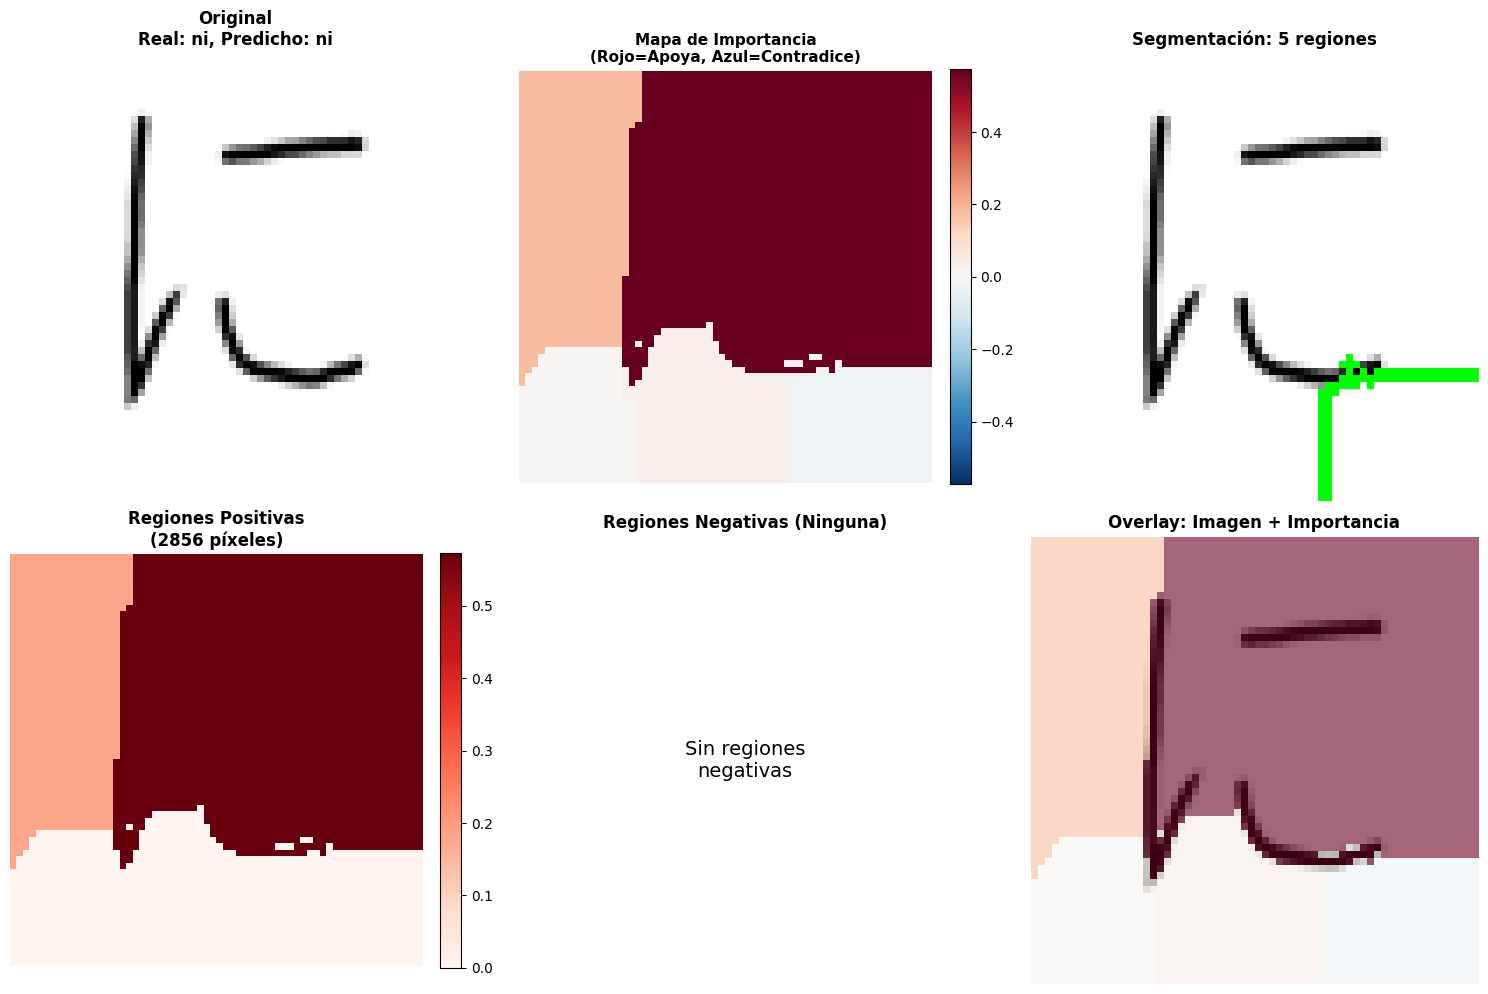


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
1        +0.5734       100.0%      APOYA fuertemente
0        +0.1773        30.9%      APOYA fuertemente
3        +0.0280         4.9%      Apoya ligeramente
4        -0.0249         4.3%      Neutral
2        +0.0047         0.8%      Apoya ligeramente

RESUMEN ESTADÍSTICO
Total de regiones: 5
Regiones positivas: 2 (40.0%)
Regiones negativas: 0 (0.0%)
Regiones neutrales: 3 (60.0%)

Peso positivo máximo: +0.5734
Peso positivo promedio: +0.3753


In [35]:
# Cargar una imagen de prueba del dataset
test_img_path = "/content/Proyecto-DeepLearning/extra_imgs/ni_test4.jpg"

img_array, predicted_class = process_and_predict_image(test_img_path, model)

# Explicar con LIME
explain_hiragana_with_lime(
    image_to_explain=img_array,
    true_label='ni',
    predicted_label=predicted_class,
    idx=1
)


EXPLICANDO IMAGEN 1
Etiqueta real: ni
Predicción del modelo: ni

Generando explicación con LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.3273, 0.3273]
Total de regiones: 7



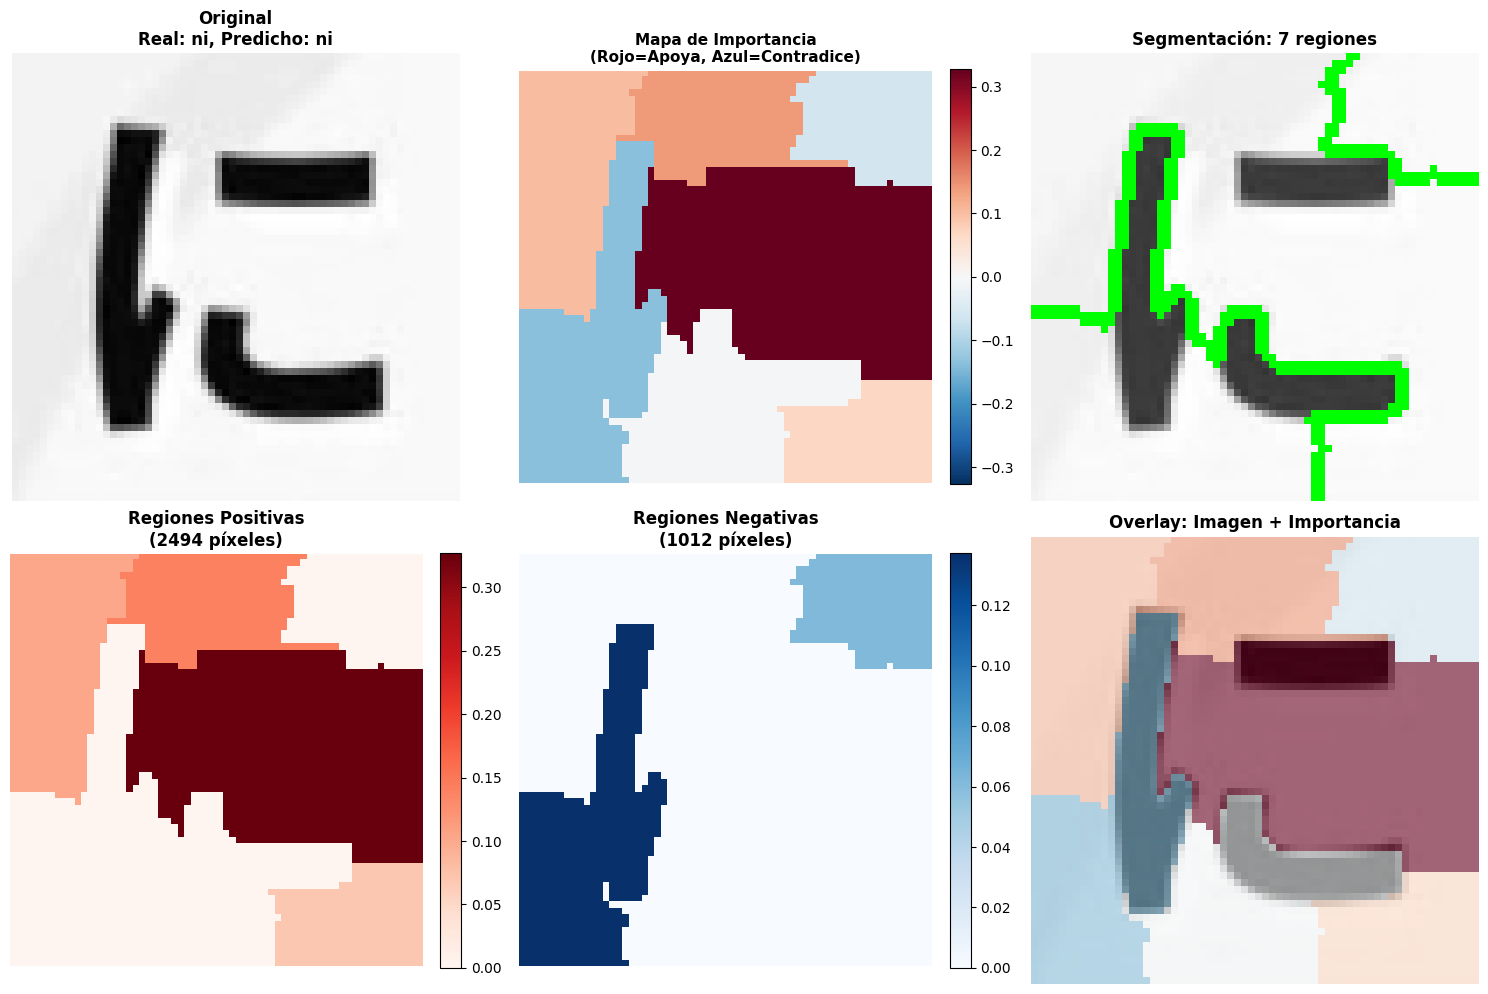


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
3        +0.3273       100.0%      APOYA fuertemente
0        +0.1394        42.6%      APOYA fuertemente
4        -0.1374        42.0%      CONTRADICE
1        +0.1021        31.2%      APOYA fuertemente
6        +0.0679        20.7%      APOYA fuertemente
2        -0.0612        18.7%      CONTRADICE
5        -0.0059         1.8%      Neutral

RESUMEN ESTADÍSTICO
Total de regiones: 7
Regiones positivas: 4 (57.1%)
Regiones negativas: 2 (28.6%)
Regiones neutrales: 1 (14.3%)

Peso positivo máximo: +0.3273
Peso positivo promedio: +0.1592
Peso negativo mínimo: -0.1374
Peso negativo promedio: -0.0993


In [36]:
# Cargar una imagen de prueba del dataset
test_img_path = "/content/Proyecto-DeepLearning/extra_imgs/ni_test.jpg"

img_array, predicted_class = process_and_predict_image(test_img_path, model)

# Explicar con LIME
explain_hiragana_with_lime(
    image_to_explain=img_array,
    true_label='ni',
    predicted_label=predicted_class,
    idx=1
)


EXPLICANDO IMAGEN 1
Etiqueta real: ni
Predicción del modelo: ni

Generando explicación con LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.3383, 0.3383]
Total de regiones: 6



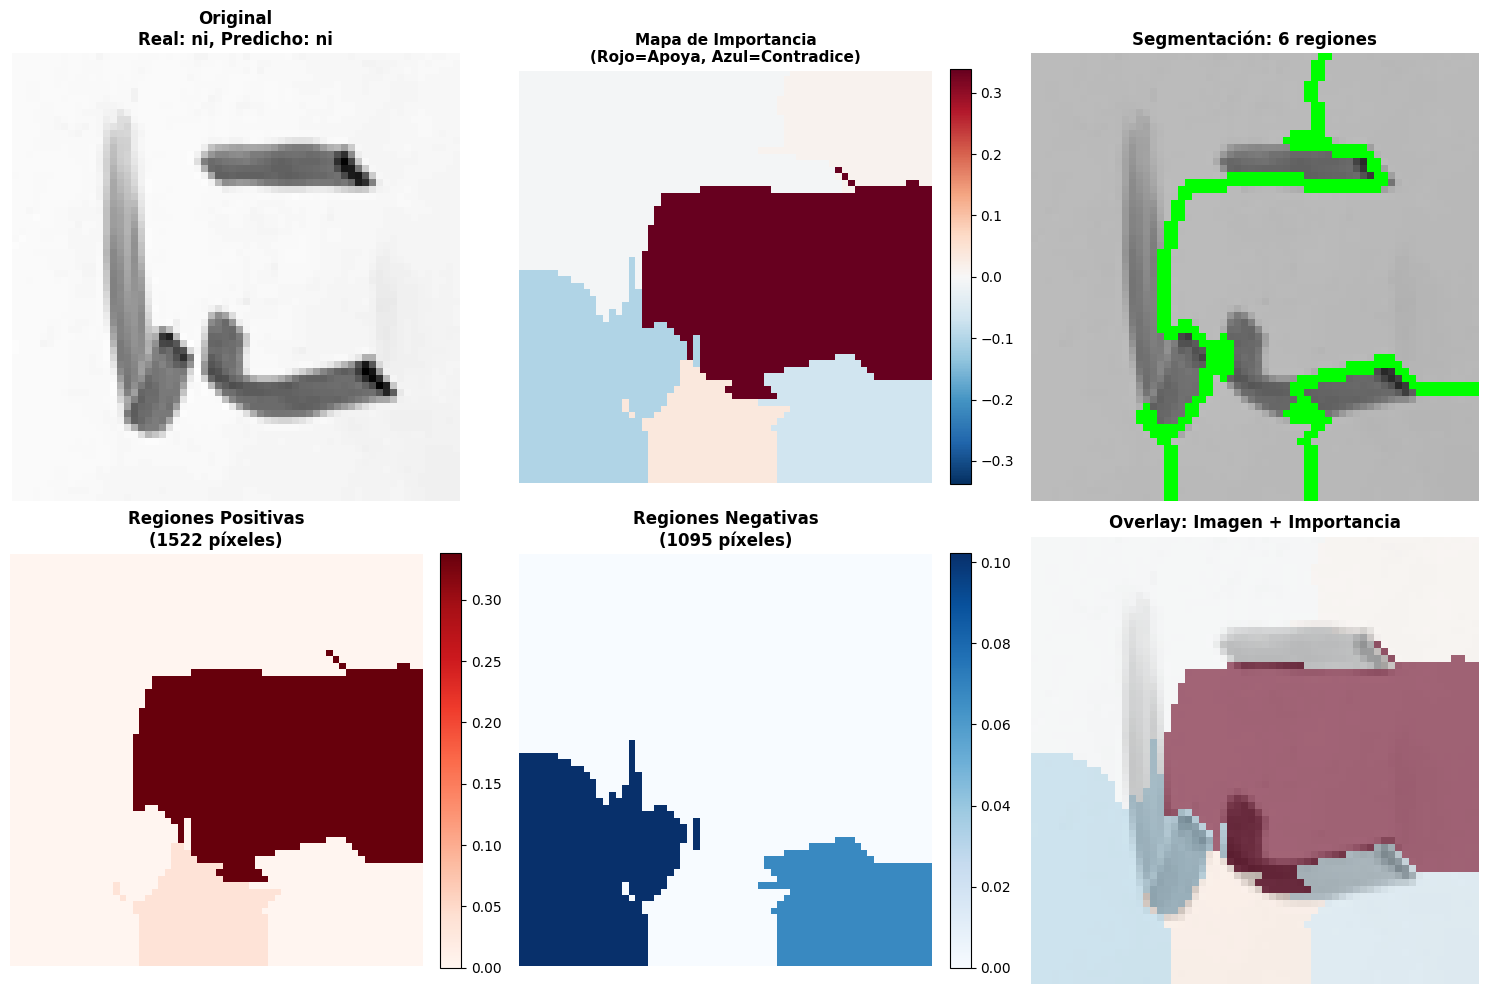


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
2        +0.3383       100.0%      APOYA fuertemente
3        -0.1023        30.2%      CONTRADICE
4        -0.0675        20.0%      CONTRADICE
5        +0.0353        10.4%      APOYA fuertemente
0        +0.0124         3.7%      Apoya ligeramente
1        -0.0067         2.0%      Neutral

RESUMEN ESTADÍSTICO
Total de regiones: 6
Regiones positivas: 2 (33.3%)
Regiones negativas: 2 (33.3%)
Regiones neutrales: 2 (33.3%)

Peso positivo máximo: +0.3383
Peso positivo promedio: +0.1868
Peso negativo mínimo: -0.1023
Peso negativo promedio: -0.0849


In [37]:
# Cargar una imagen de prueba del dataset
test_img_path = "/content/Proyecto-DeepLearning/extra_imgs/ni_testL.jpeg"

img_array, predicted_class = process_and_predict_image(test_img_path, model)

# Explicar con LIME
explain_hiragana_with_lime(
    image_to_explain=img_array,
    true_label='ni',
    predicted_label=predicted_class,
    idx=1
)


EXPLICANDO IMAGEN 1
Etiqueta real: ta
Predicción del modelo: ta

Generando explicación con LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.2886, 0.2886]
Total de regiones: 6



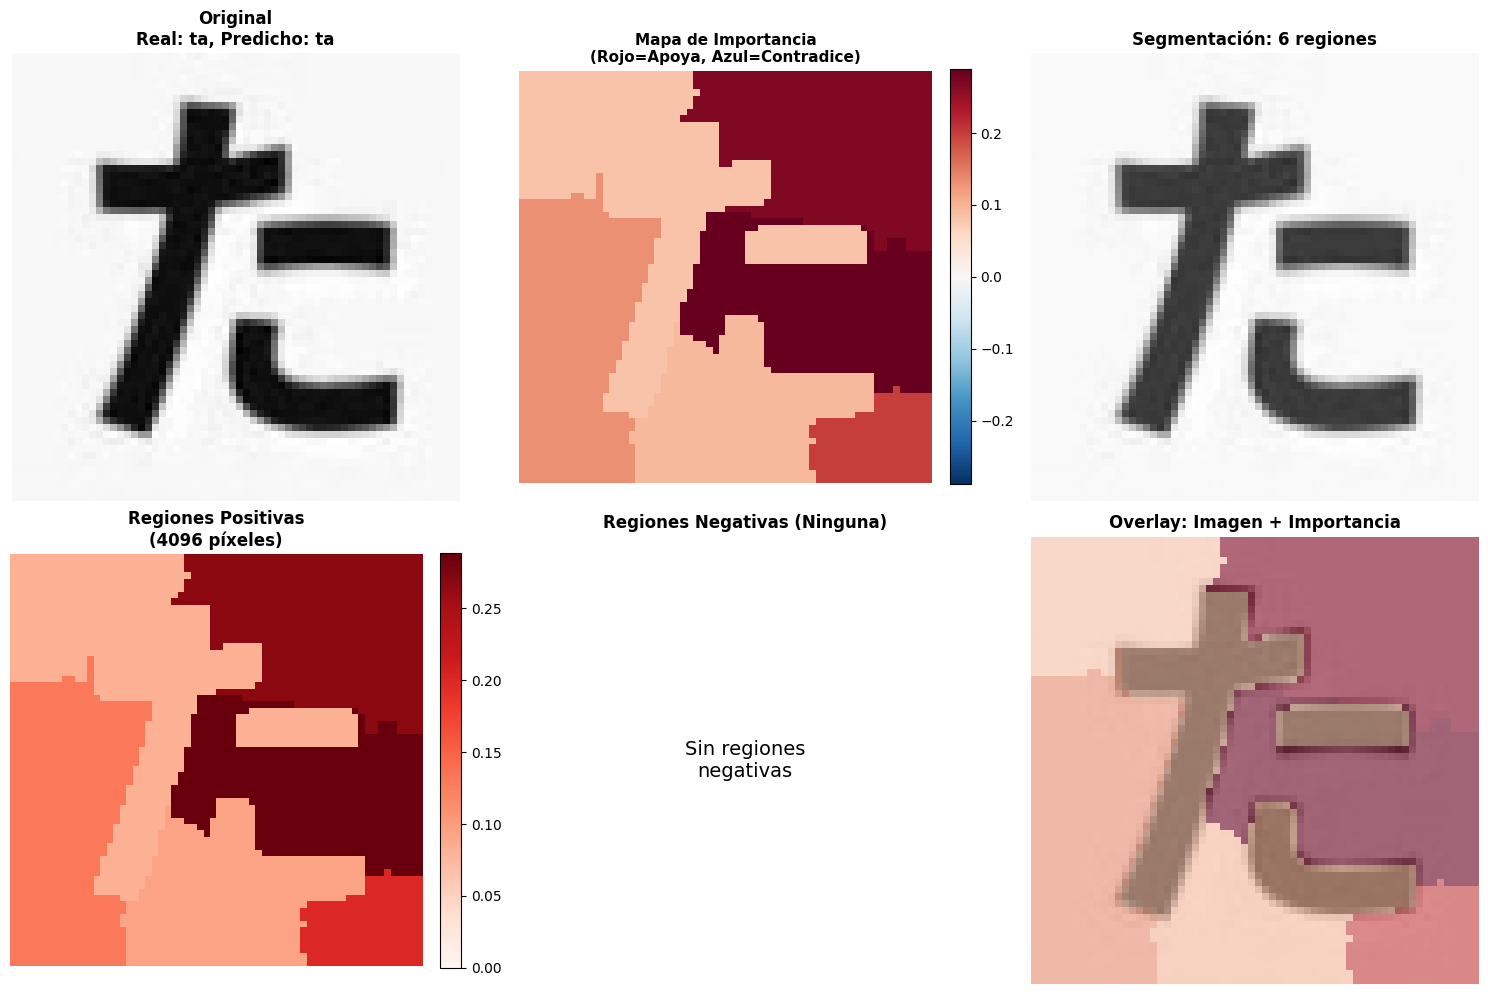


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
3        +0.2886       100.0%      APOYA fuertemente
1        +0.2668        92.5%      APOYA fuertemente
5        +0.1995        69.1%      APOYA fuertemente
2        +0.1315        45.6%      APOYA fuertemente
4        +0.0927        32.1%      APOYA fuertemente
0        +0.0815        28.2%      APOYA fuertemente

RESUMEN ESTADÍSTICO
Total de regiones: 6
Regiones positivas: 6 (100.0%)
Regiones negativas: 0 (0.0%)
Regiones neutrales: 0 (0.0%)

Peso positivo máximo: +0.2886
Peso positivo promedio: +0.1768


In [38]:
# Cargar una imagen de prueba del dataset
test_img_path = "/content/Proyecto-DeepLearning/extra_imgs/ta_test.jpg"

img_array, predicted_class = process_and_predict_image(test_img_path, model)

# Explicar con LIME
explain_hiragana_with_lime(
    image_to_explain=img_array,
    true_label='ta',
    predicted_label=predicted_class,
    idx=1
)


EXPLICANDO IMAGEN 1
Etiqueta real: ko
Predicción del modelo: ta

Generando explicación con LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.0626, 0.0626]
Total de regiones: 4



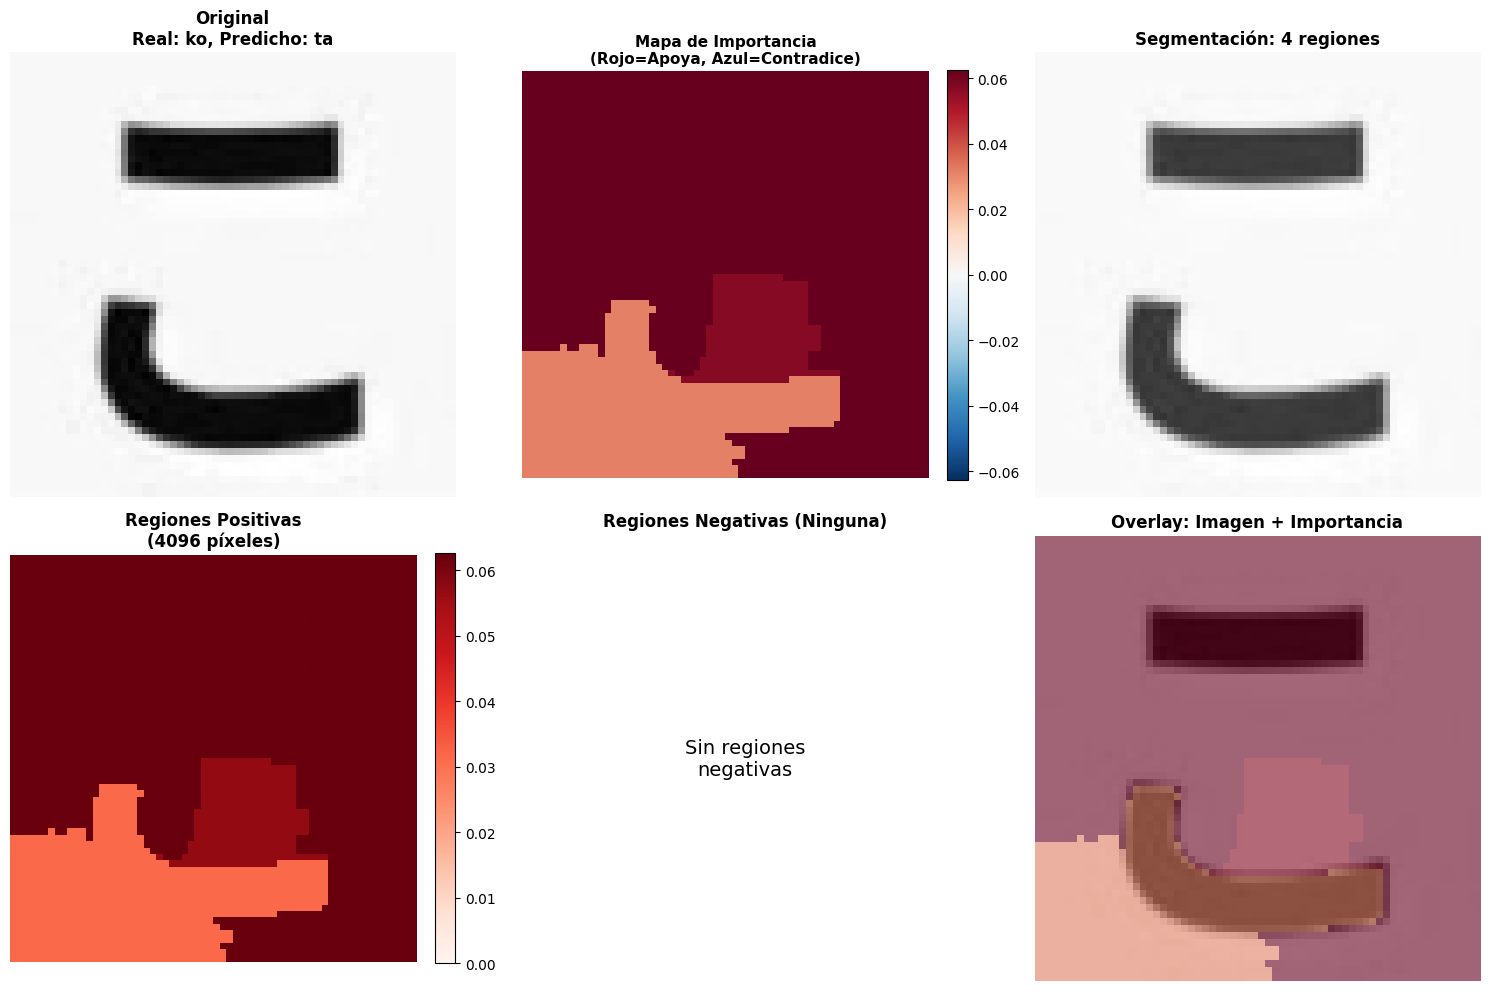


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
1        +0.0626       100.0%      APOYA fuertemente
0        +0.0622        99.5%      APOYA fuertemente
2        +0.0568        90.8%      APOYA fuertemente
3        +0.0314        50.3%      APOYA fuertemente

RESUMEN ESTADÍSTICO
Total de regiones: 4
Regiones positivas: 4 (100.0%)
Regiones negativas: 0 (0.0%)
Regiones neutrales: 0 (0.0%)

Peso positivo máximo: +0.0626
Peso positivo promedio: +0.0533


In [39]:
# Cargar una imagen de prueba del dataset
test_img_path = "/content/Proyecto-DeepLearning/extra_imgs/ko_test.jpg"

img_array, predicted_class = process_and_predict_image(test_img_path, model)

# Explicar con LIME
explain_hiragana_with_lime(
    image_to_explain=img_array,
    true_label='ko',
    predicted_label=predicted_class,
    idx=1
)

# Re y Ne test


EXPLICANDO IMAGEN 1
Etiqueta real: re
Predicción del modelo: re

Generando explicación con LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.3644, 0.3644]
Total de regiones: 6



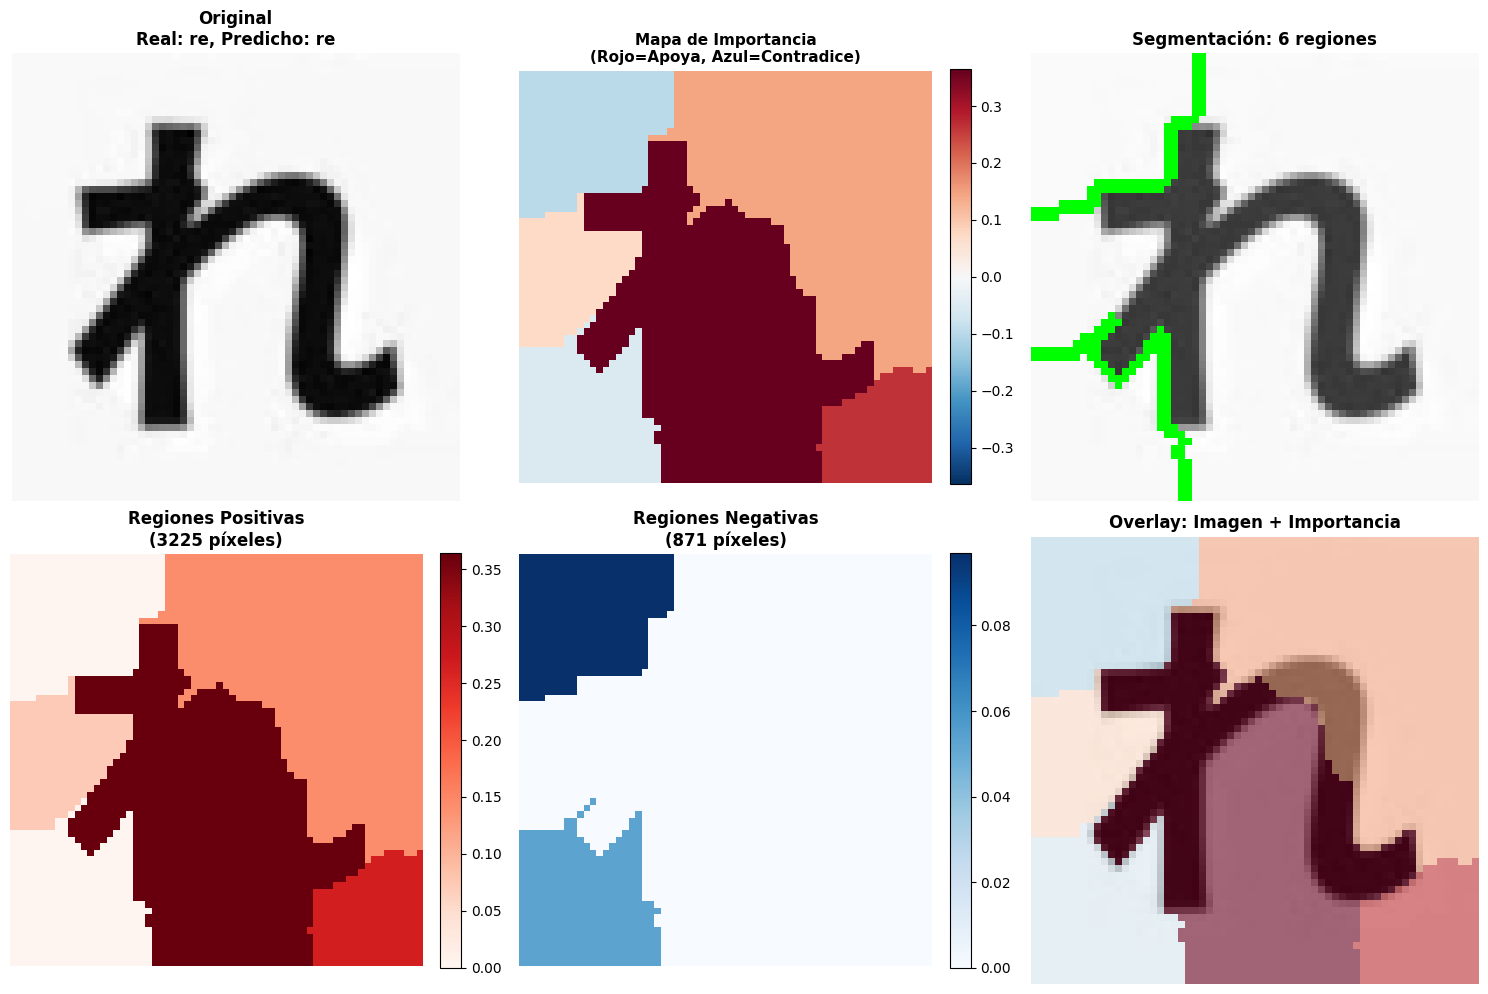


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
4        +0.3644       100.0%      APOYA fuertemente
5        +0.2636        72.3%      APOYA fuertemente
1        +0.1434        39.3%      APOYA fuertemente
0        -0.0970        26.6%      CONTRADICE
2        +0.0712        19.5%      APOYA fuertemente
3        -0.0530        14.5%      CONTRADICE

RESUMEN ESTADÍSTICO
Total de regiones: 6
Regiones positivas: 4 (66.7%)
Regiones negativas: 2 (33.3%)
Regiones neutrales: 0 (0.0%)

Peso positivo máximo: +0.3644
Peso positivo promedio: +0.2107
Peso negativo mínimo: -0.0970
Peso negativo promedio: -0.0750


In [40]:
# Cargar una imagen de prueba del dataset
test_img_path = "/content/Proyecto-DeepLearning/extra_imgs/re_test.jpg"

img_array, predicted_class = process_and_predict_image(test_img_path, model)

# Explicar con LIME
explain_hiragana_with_lime(
    image_to_explain=img_array,
    true_label='re',
    predicted_label=predicted_class,
    idx=1
)


EXPLICANDO IMAGEN 1
Etiqueta real: ne
Predicción del modelo: ne

Generando explicación con LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.5603, 0.5603]
Total de regiones: 7



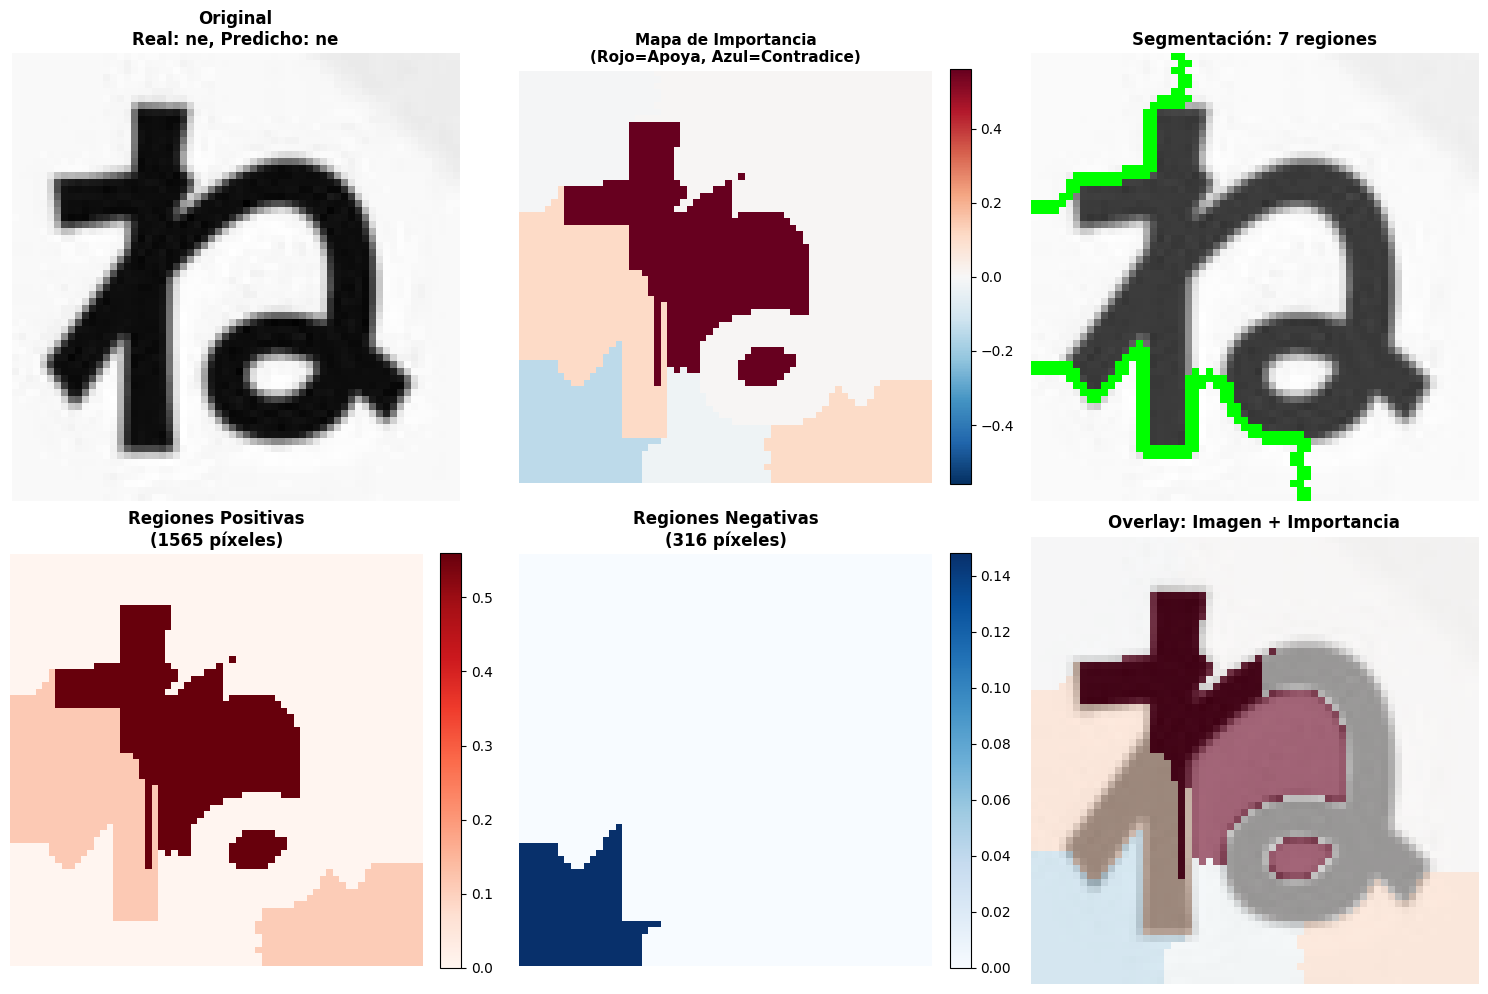


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
2        +0.5603       100.0%      APOYA fuertemente
4        -0.1482        26.5%      CONTRADICE
3        +0.1136        20.3%      APOYA fuertemente
5        +0.1084        19.4%      APOYA fuertemente
6        -0.0249         4.4%      Neutral
0        -0.0076         1.4%      Neutral
1        +0.0064         1.2%      Apoya ligeramente

RESUMEN ESTADÍSTICO
Total de regiones: 7
Regiones positivas: 3 (42.9%)
Regiones negativas: 1 (14.3%)
Regiones neutrales: 3 (42.9%)

Peso positivo máximo: +0.5603
Peso positivo promedio: +0.2608
Peso negativo mínimo: -0.1482
Peso negativo promedio: -0.1482


In [41]:
# Cargar una imagen de prueba del dataset
test_img_path = "/content/Proyecto-DeepLearning/extra_imgs/ne_test.jpg"

img_array, predicted_class = process_and_predict_image(test_img_path, model)

# Explicar con LIME
explain_hiragana_with_lime(
    image_to_explain=img_array,
    true_label='ne',
    predicted_label=predicted_class,
    idx=1
)


EXPLICANDO IMAGEN 1
Etiqueta real: ni
Predicción del modelo: ku

Generando explicación con LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

Explicación generada

Rango de visualización: [-0.3237, 0.3237]
Total de regiones: 3



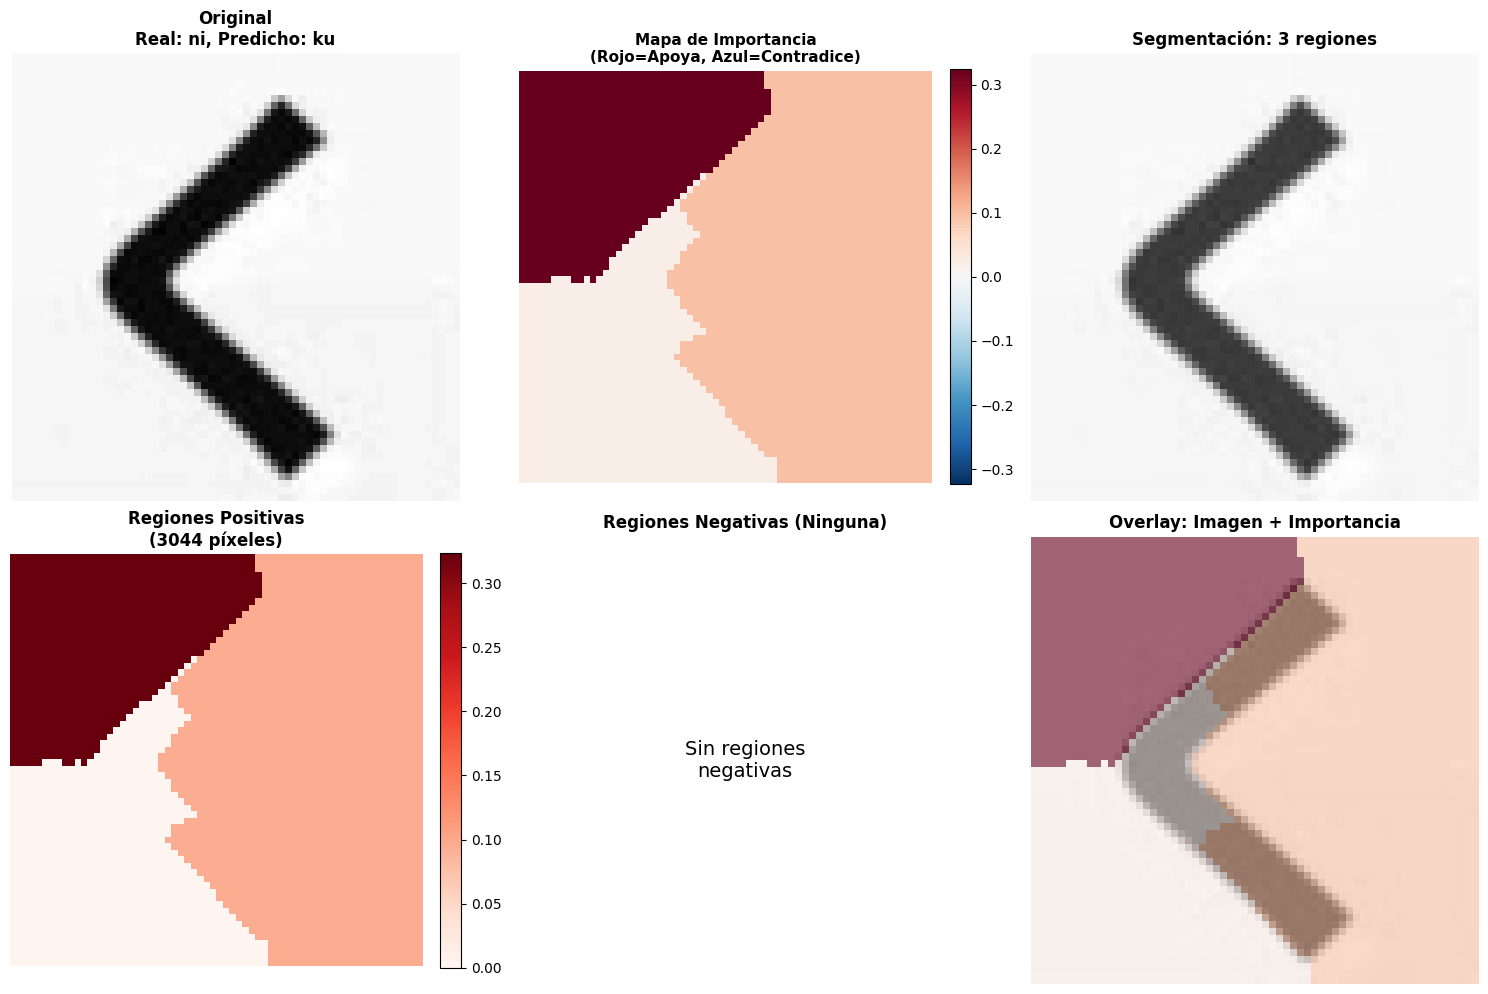


ANÁLISIS NUMÉRICO DE REGIONES

Region     Peso         % del Max    Interpretación                
----------------------------------------------------------------------
0        +0.3237       100.0%      APOYA fuertemente
1        +0.0949        29.3%      APOYA fuertemente
2        +0.0211         6.5%      Apoya ligeramente

RESUMEN ESTADÍSTICO
Total de regiones: 3
Regiones positivas: 2 (66.7%)
Regiones negativas: 0 (0.0%)
Regiones neutrales: 1 (33.3%)

Peso positivo máximo: +0.3237
Peso positivo promedio: +0.2093


In [42]:
# Cargar una imagen de prueba del dataset
test_img_path = "/content/Proyecto-DeepLearning/extra_imgs/ku_test.jpg"

img_array, predicted_class = process_and_predict_image(test_img_path, model)

# Explicar con LIME
explain_hiragana_with_lime(
    image_to_explain=img_array,
    true_label='ni',
    predicted_label=predicted_class,
    idx=1
)